In [1]:
import sys; sys.path.insert(0, '..')

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

import trajectory_reconstruction_tradeoff as T
import random
import scanpy as sc
import altair as alt
from altair_saver import save
from sklearn import linear_model

random.seed(20)

In [2]:
dirname = '/cs/labs/mornitzan/nomoriel/trajectory_reconstruction_tradeoff/'

In [3]:
trajs = {}

nc = 500
ngenes = 20

endpoint1 = np.random.randint(0,10, size=ngenes)
endpoint2 = np.random.randint(0,10, size=ngenes)
X = T.io.line_trajectory(nc, endpoint1=endpoint1, endpoint2=endpoint2, std=1/ngenes)

trajs['line'] = T.tr.Trajectory(X)
trajs['line_no_log'] = T.tr.Trajectory(X, do_log1p=False)

newick_string = '((((A:100)B:100)C:100)D:100)E:100;'
X, _, meta = T.io.prosstt_trajectory(newick_string, genes=ngenes)
trajs['prosstt'] = T.tr.Trajectory(X, meta=meta)
trajs['prosstt_no_log'] = T.tr.Trajectory(X, meta=meta, do_log1p=False)

dirname = '/cs/labs/mornitzan/nomoriel/trajectory_reconstruction_tradeoff/'
# datadir = os.path.join(dirname, 'datasets/')
# X, _, meta = T.io.read_dataset(dataset='hayashi', dirname=datadir)
# trajs['hayashi'] = T.tr.Trajectory(X, meta=meta)


/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


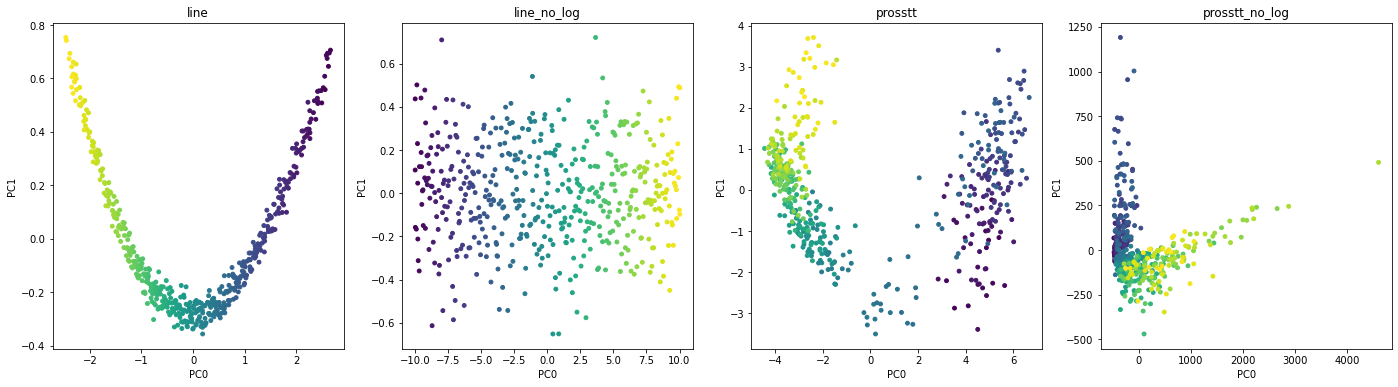

In [6]:
fig, ax = plt.subplots(1,len(trajs),figsize=(6*len(trajs),6))
for itraj, (traj_desc, traj) in enumerate(trajs.items()):
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, color='original_idx', color_type='Q', ax=ax[itraj], title=traj_desc)

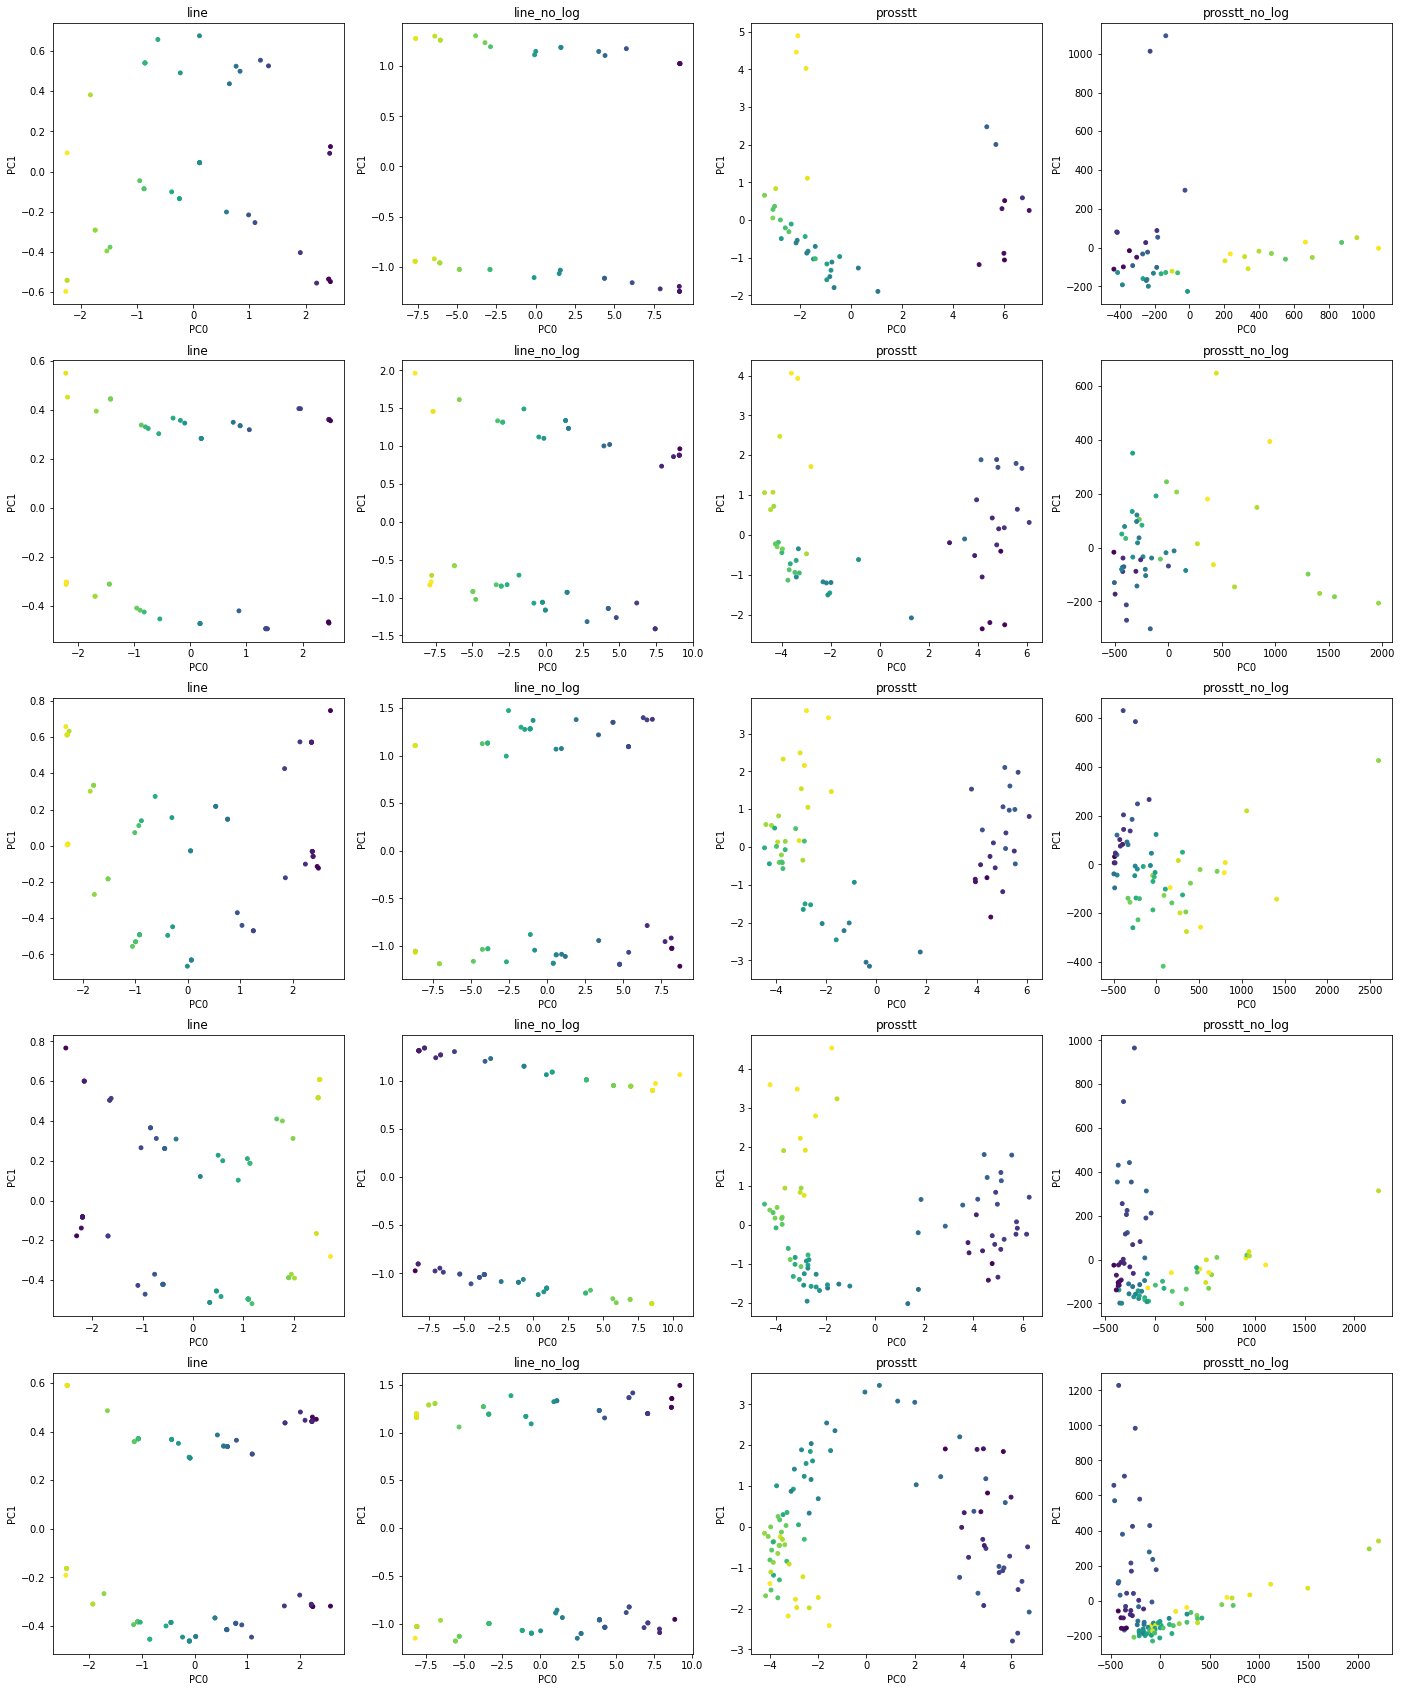

In [20]:
Pvar = 0.01 * 2 ** np.arange(0, 6, 0.3)
repeats = 50
Pconst = np.ones_like(Pvar)

idxs = np.arange(10,15).astype(int)
fig, ax = plt.subplots(len(idxs),len(trajs),figsize=(6*len(trajs),6*len(idxs)))
for itraj, (traj_desc, traj) in enumerate(trajs.items()):
    for iidx, idx in enumerate(idxs):
        sX, psX, psD, sD, ix = traj.subsample(pc=Pvar[idx], pt=Pconst[idx])
        T.pl.plot_pca2d(psX, meta=traj.meta.iloc[ix], color='original_idx', color_type='Q', ax=ax[iidx, itraj], title=traj_desc)

In [7]:
L_cells_dict = {}
for traj_desc, traj in trajs.items():
    # sample cells
    # Pvar = np.round(0.03 * 2 ** np.arange(0, 5, 0.3), 2)
    L_cells = traj.compute_tradeoff(B=-1, Pt=Pconst, Pc=Pvar, repeats=repeats, comp_deltas=True, comp_nn_dist=True)
    L_cells['log pc'] = np.log(L_cells['pc'])
    L_cells_dict[traj_desc] = L_cells.copy()

    # L_cells.to_csv(os.path.join(outdir, 'prosstt_L_cells.csv'))
    # print(L_cells.shape)

array([0.01      , 0.01231144, 0.01515717, 0.01866066, 0.02297397,
       0.02828427, 0.03482202, 0.04287094, 0.05278032, 0.06498019,
       0.08      , 0.09849155, 0.12125733, 0.14928528, 0.18379174,
       0.22627417, 0.27857618, 0.34296751, 0.42224253, 0.51984153])

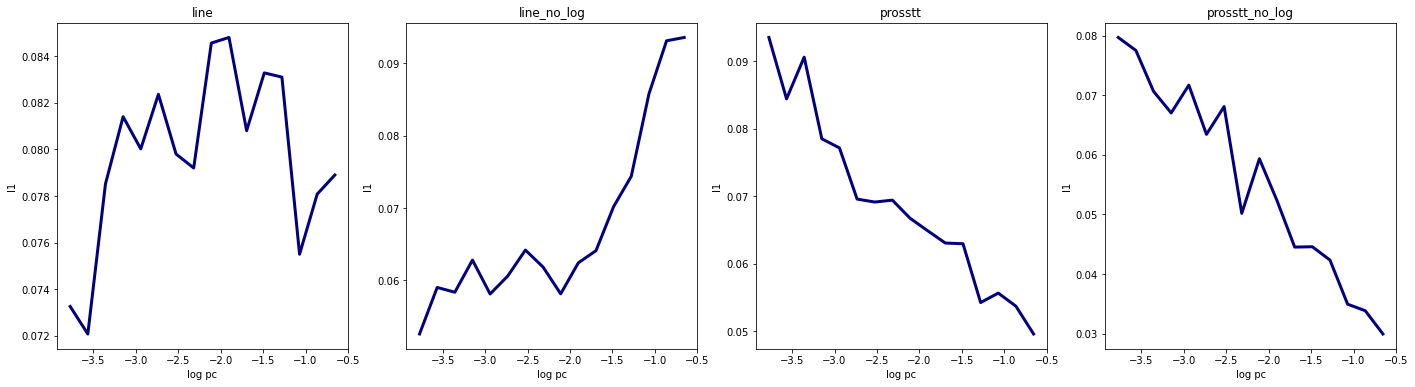

In [12]:
xcol = 'log pc'
ycol = 'l1'
# ycol = 'l1'
fig, ax = plt.subplots(1,len(trajs),figsize=(6 * len(trajs),6))
for itraj, (traj_desc, L_cells) in enumerate(L_cells_dict.items()):
    T.pl.plot_tradeoff(L_cells, xcol=xcol, ycol=ycol, plot_std=0, title=traj_desc, ax=ax[itraj], xlabel=xcol, ylabel=ycol)

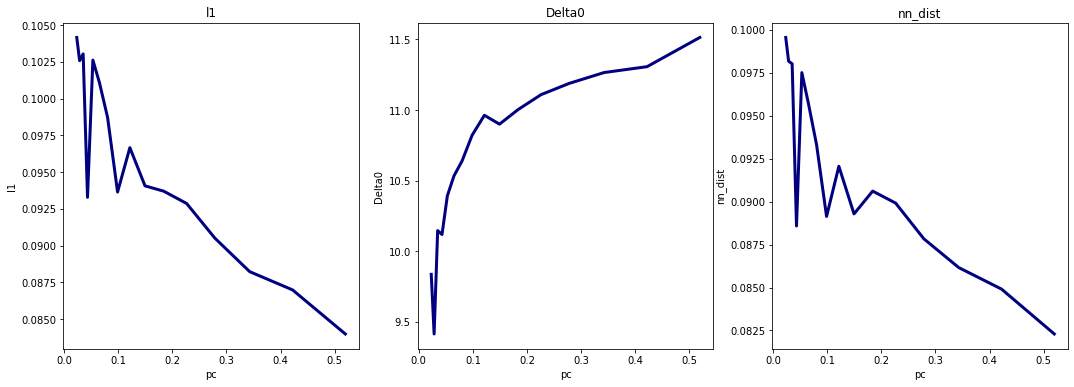

In [ ]:
traj_desc = 'prosstt'
L_cells = L_cells_dict[traj_desc]

xcol = 'pc'
ycols = ['l1', 'Delta0', 'nn_dist']
# ycol = 'l1'
fig, ax = plt.subplots(1,len(ycols),figsize=(len(ycols)*6,6))
for iycol, ycol in enumerate(ycols):
    T.pl.plot_tradeoff(L_cells, xcol=xcol, ycol=ycol, plot_std=0, title=ycol, ax=ax[iycol],ylabel=ycol, xlabel=xcol)

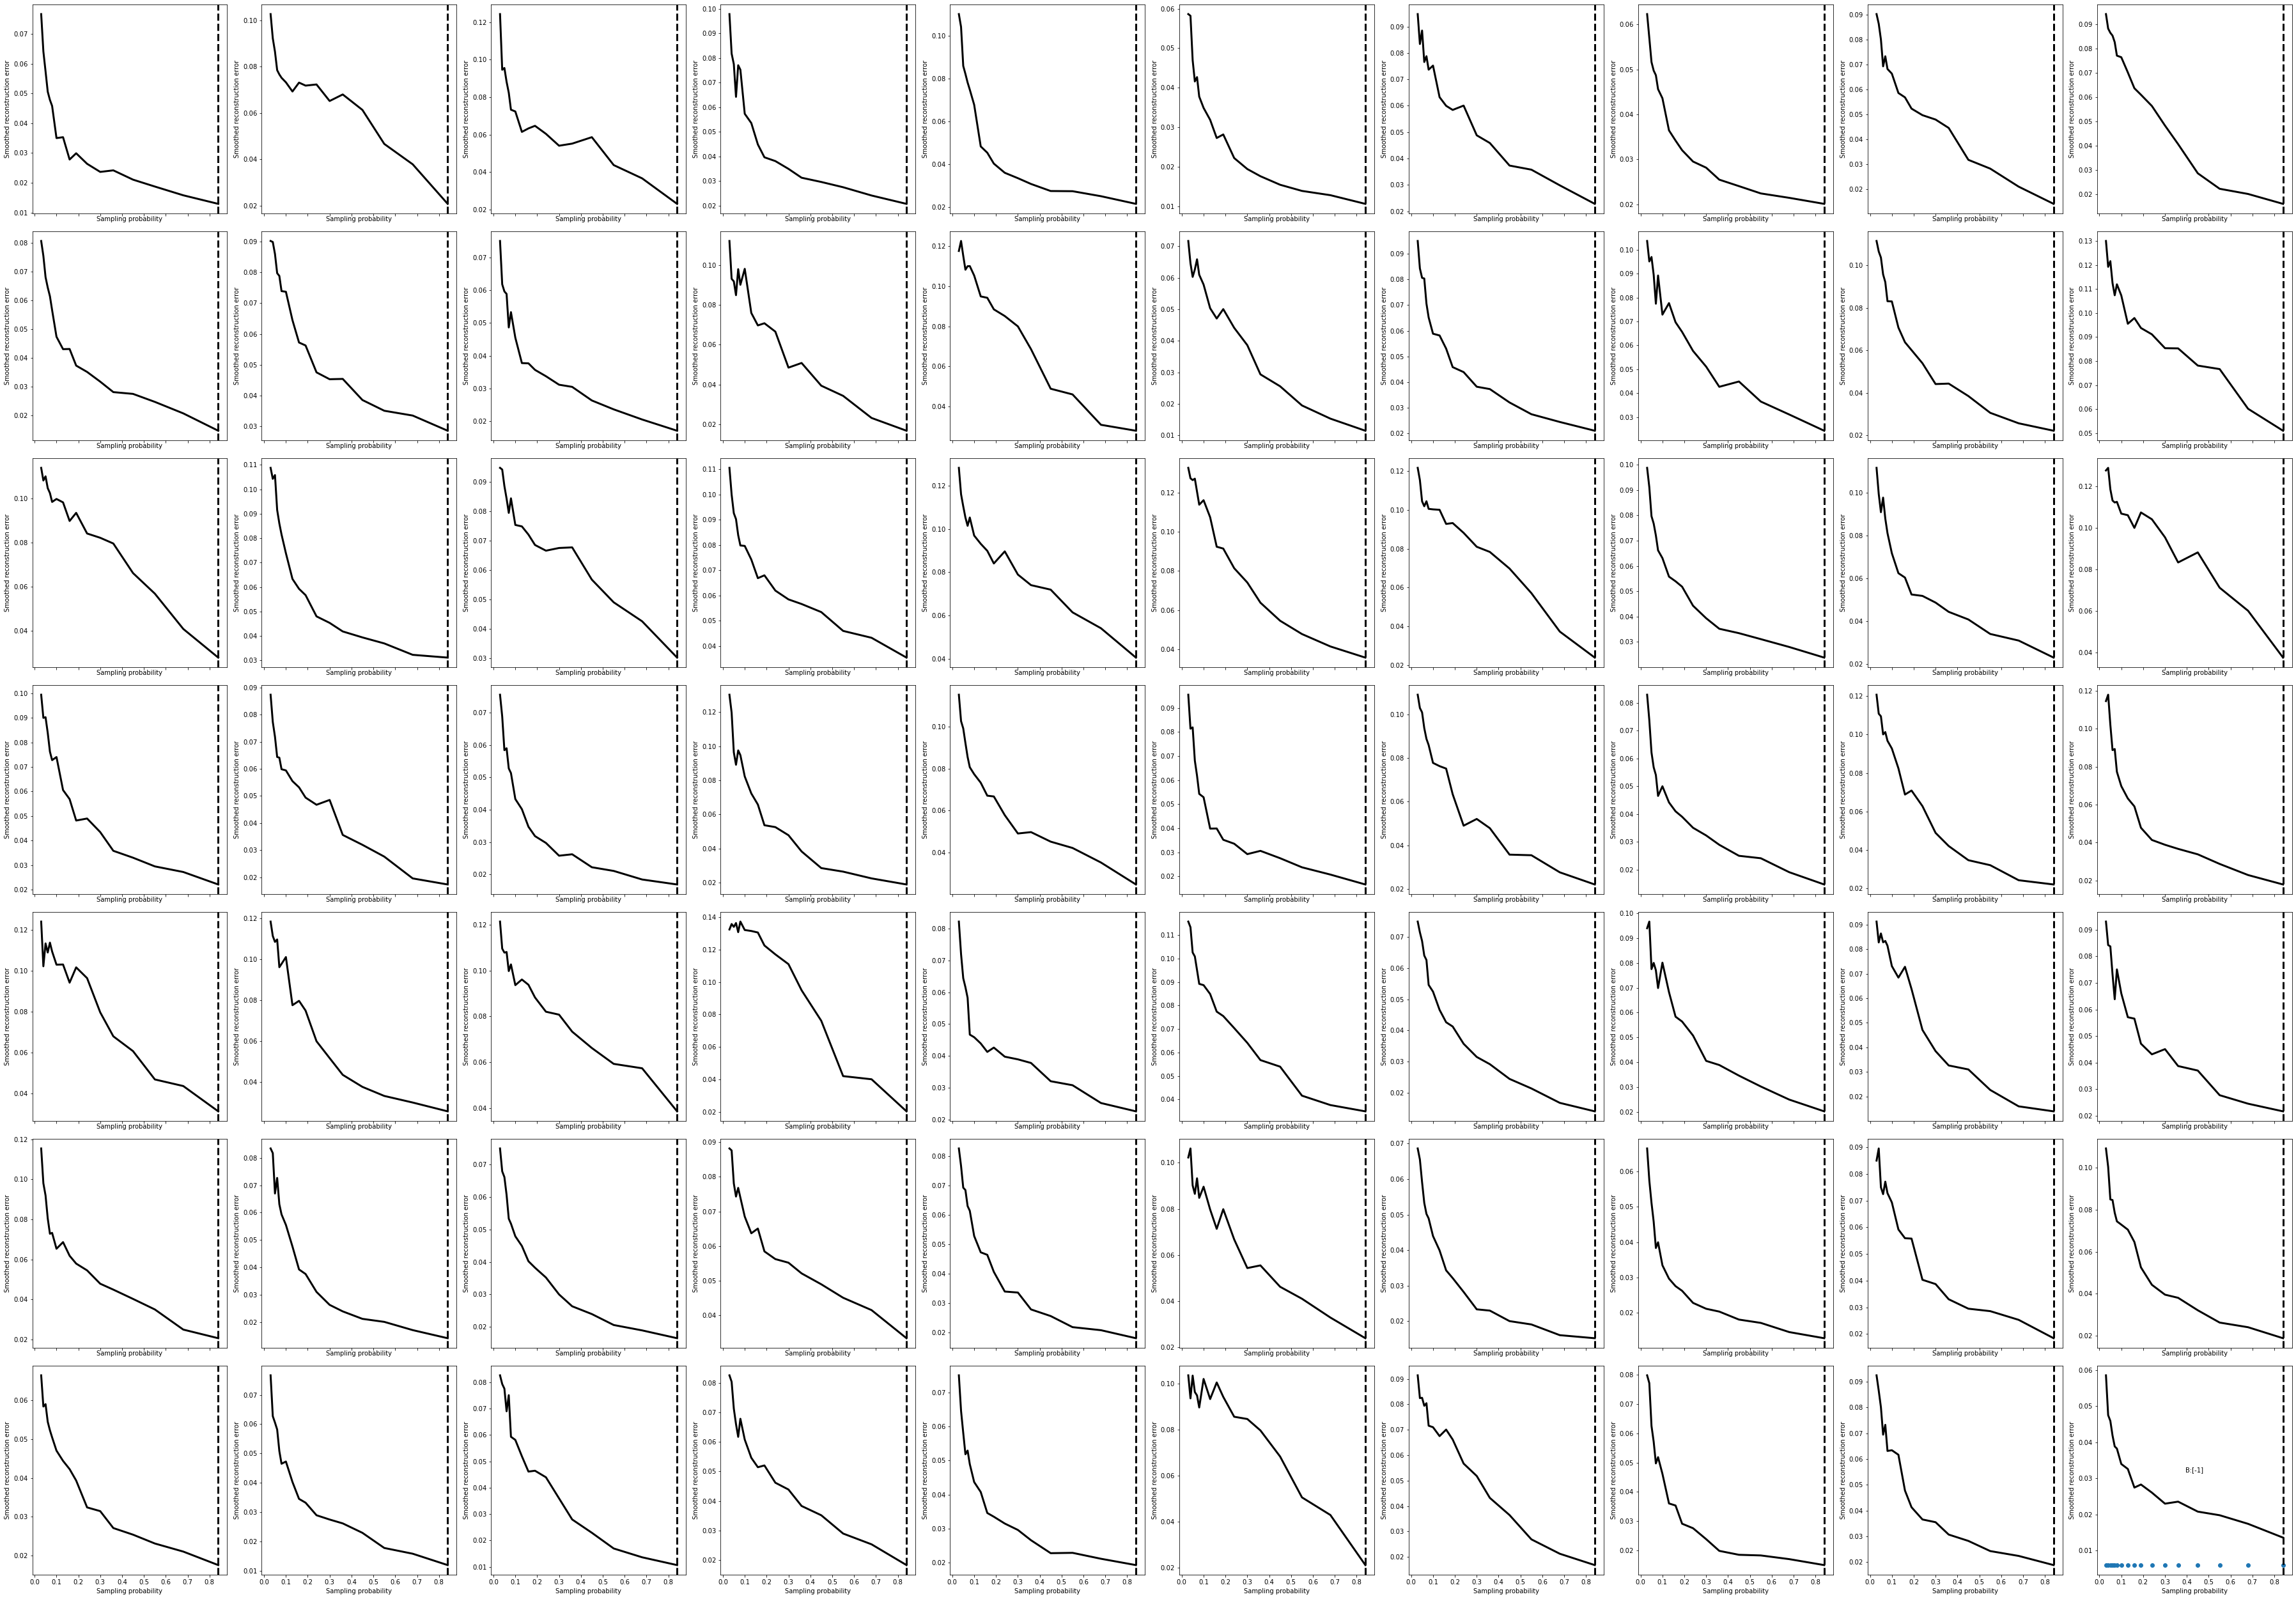

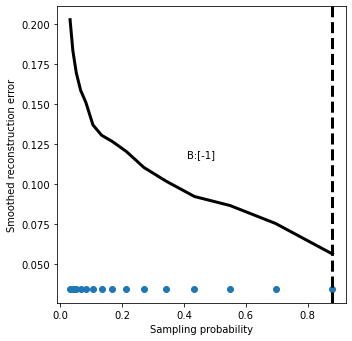

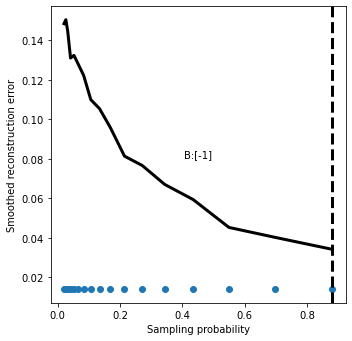

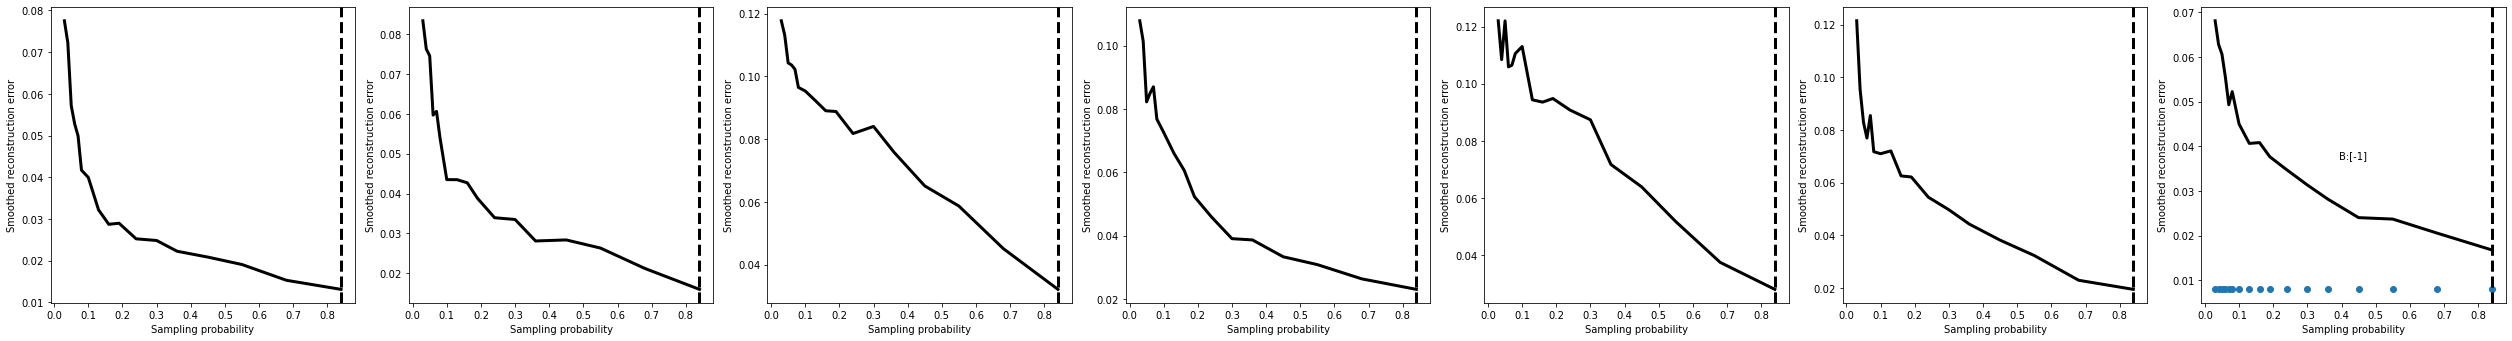

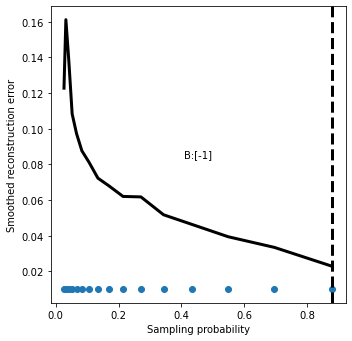

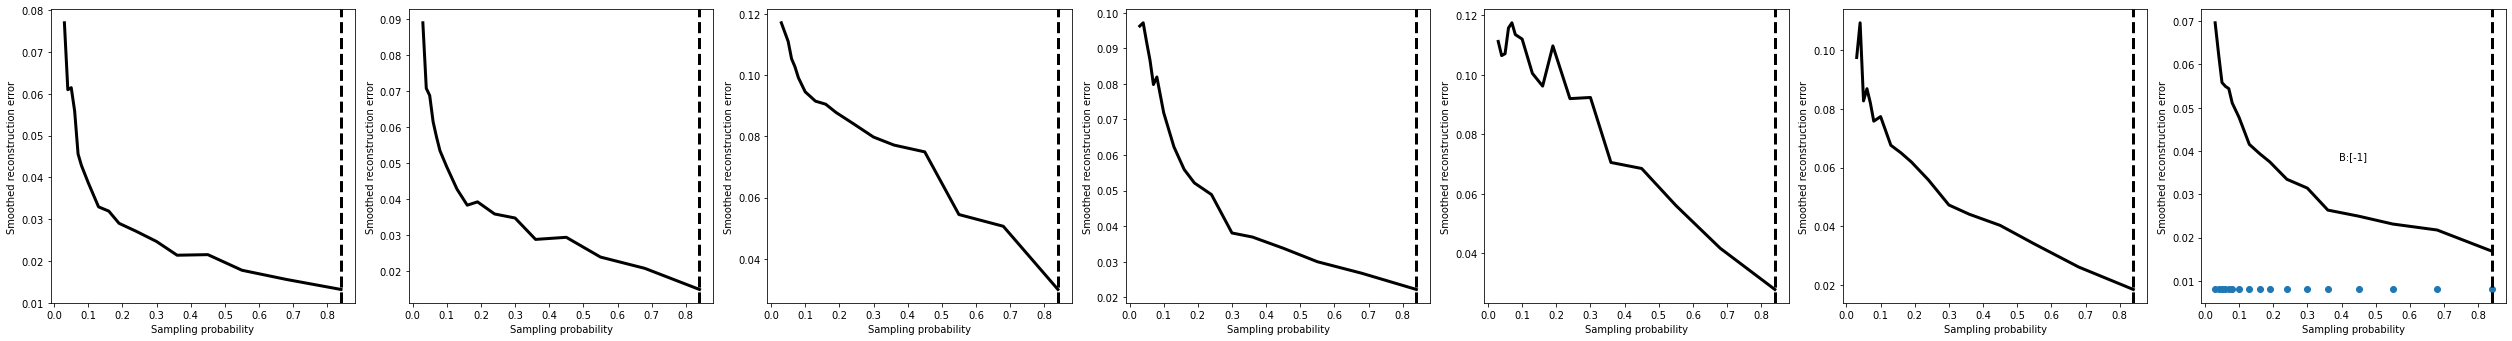

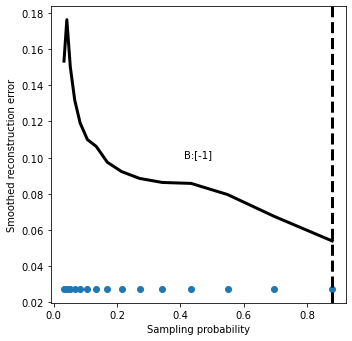

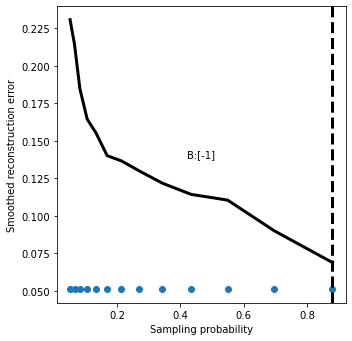

In [ ]:
# for fname in glob.glob(os.path.join(dirname, 'output', '*L_cells*.csv')):
#     L_cells = pd.read_csv(fname)
#     L_cells['log pc'] = np.log(L_cells['pc'])
#     T.pl.plot_tradeoff_experiments(L_cells, xcol='pc', ycol='l1')
